# Simulation
## Direction finding with compact Volumetric Acoustic Sensor (cVAS)

The following script demonstrates different methods to estimate the direction of sound sources using a comapct volumetric acoustic sensor. Sound sources are simulated to provide the opportunity to assess the quality of the direction estimations.

note to myself: jupyter nbconvert cVAS_direction.ipynb --to html

### Loading libraries
First, some basic libraries are imported and general parameter defined.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

plt.rc('font', size=15)


### Miscellaneous utilities
Some basic utilities are defined. In particular, a fft based overlap-and-add algorithm is modified for multi-channel filtering. This algorithm is then the base of a hilbert transform and matched filter implementation. A quadratic inperpolation method for obtaining the location and value of a theorectical maximum within a time series.

In [2]:
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
# modified by WMXZ to work on multi-channel data
#
def fft_filt(b, x, zi=None, nh=0):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.
    nh : time shift of result (group delay)

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    if x.ndim==1: x=x.reshape(-1,1)
    if b.ndim==1: b=b.reshape(-1,1)
    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig,N_sig = x.shape
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros((L_sig+L_F,N_sig), dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros((L_sig+L_F,N_sig))

    FDir = fft_func(b, n=L_F,axis=0)

    # overlap and add
    for n in offsets:
        res[n:n+L_F,:] += ifft_func(fft_func(x[n:n+L_S,:], n=L_F,axis=0)*FDir,axis=0)

    if zi is not None:
        res[:zi.shape[0],:] = res[:zi.shape[0],:] + zi
        zi=res[L_sig:,:]
        return res[nh:nh+L_sig,:],zi 
    else:
        return res[nh:nh+L_sig,:]

def hilbert_filt(ss,nh):
    # generate hilbert response (complex valued)
    hk=np.pi*np.arange(-nh,nh+1)
    hk[nh]=1        # to avoid division by 0; will be corrected below
    #
    hh= 0*hk+1j*(1-np.cos(hk))/hk
    hh[nh]=1+1j*0   # correct previous adjustment
    #
    zz=fft_filt(hh,ss,nh=nh)
    return zz

def matched_filt(xx,ss):
    # xx is signal for replica
    # ss us data to be filtered
    #
    # for matched filter
    nd=np.shape(xx)[0]
    rep=np.flipud(xx)/np.sqrt((nd/2*np.sum(xx**2)))
    #
    zz=fft_filt(rep,ss,nh=len(rep)//2)
    return zz
#
def quadInt(uu,imx,nd1):
    # three point quardatic interpolation 
    # to find location and value of interpolated maxima
    nc=len(imx)
    uo=uu[imx,range(nc)]
    um=uu[imx-1,range(nc)]
    up=uu[imx+1,range(nc)]

    b=(up+um-2*uo)/2;

    xo=(um-up)/(4*b);
    yo=uo-b*xo**2;
    
    ux=np.zeros((nc,2))
    ux[:,0]=xo+imx-nd1
    ux[:,1]=yo
    return ux
#

### Simulation and processing support functions
For the simulation and processing a series of functions are defined
 - **cvas_array**: defines the volumetric array and provides the matrix that is needed to transform measurements to directional components
 - **signalPath**: estimates the arrival angle and relative travel times to the hydrophones (referenced to center of array) assuming source distance much larger than the array dimension (i.e. same angle for all hydrophones)
 - **geometry**: simulate multi-path 
 - **LFM_simulate**: generate LFM signal
 - **map_array**: delay signal according to array geometry and add measurement noise.

In [3]:
# cVAS hydrophones
# octahedron (x points from 'centre' towards hydrophone 1)
def cvas_array():
    ro=0.040 # m
    dz=np.sqrt(2)
    ang=np.array([0,120,240,60,180,300])*np.pi/180
    #
    ho=np.empty((len(ang),3))
    ho[:,:]=np.transpose([np.cos(ang[:]),np.sin(ang[:]),-dz/2+0*ang[:]])
    ho[3:,2] += dz
    ho *= ro
    isel=np.array([[0,1],[0,2],[0,3],[0,4],[0,5],
                    [1,2],[1,3],[1,4],[1,5],
                    [2,3],[2,4],[2,5],
                    [3,4],[3,5],
                    [4,5]])

    nc=np.shape(isel)[0]

    D=ho[isel[:,1],]-ho[isel[:,0],]
    L=np.sqrt(np.sum(D**2,1))
    print(0.75/L, 'kHz')
    DI=np.linalg.pinv(D)
    return DI,isel,ho,L

def signalPath(dx,dy,az,ho):
    r1=np.sqrt(dx**2 + dy**2)
    el1=np.arctan2(dy,dx)
    #
    S1=np.array([np.cos(az)*np.cos(el1),np.sin(az)*np.cos(el1), np.sin(el1)])
    DC1=np.sum(ho*S1,1)
    DT1=DC1/1.500   # ms
    return DT1,el1,r1

def geometry(hd,sd,dx,bd,az,ho):
    #simulate signal arrival direct, surface and bottom reflected
#    az=150*np.pi/180
#    bd=900 # bottom depth m
#    hd=500 # hydrophone depth m
#    sd=800 # source depth m
#    dx=5000 # source distance m
    #

    #hydrophone delay simulation
    #direct arrival
    DT1,el1,r1=signalPath(dx,hd-sd,az,ho)
    #surface reflected
    DT2,el2,r2=signalPath(dx,hd+sd,az,ho)
    #bottom reflected
    DT3,el3,r3=signalPath(dx,hd-(2*bd-sd),az,ho)

    dt2 = (r2-r1)/1.5     # ms
    dt3 = (r3-r1)/1.5     # ms

    print('Angles: ',np.array([az,el1,el2,el3])*180/np.pi)
    print('Time delays: ',dt2,dt3)

    print(DT1, 'ms')
    print(DT2, 'ms')
    print(DT3, 'ms')
    return [DT1,DT2,DT3],[el1,el2,el3],[r1,r2,r3]

def LFM_simulate(fs,t2,f1,f2,to,te):
    # Simulate LFM
#    fs=96000    # sampling frequency (Hz)
#    t2=5        # LFM duration (s)

#    f1=0        # LFM start frequency (Hz)
#    f2=24000    # LFM stop frequency (Hz)
#    to=1        # signal start time (to>=0)
#    te=10       # data end time (te>=to+t2) 
#
    # generate time vector
    tt=np.arange(0,t2,1/fs)
    # generate modulation frequency
    om=2*np.pi*(f1+(f2-f1)/2*tt/t2)
    #
    xx=np.sin(om*tt)
    #
    # prepare some more space than needed for signal
    iyo=int(to*fs)
    iye=int(te*fs)
    yy=np.zeros(iye)
    #
    yy[iyo:iyo+len(xx)]+=xx
    ty=np.arange(len(yy))/fs
    fr=f1+(f2-f1)*tt/t2
    return yy,fs,ty,xx,fr
#
def map_array(yy,fs,DT1,noise):
    # delay signal according to array geometry 
    # (use fractional delay with sinc function)
    kk=np.arange(-10,10,1);
    ss=np.zeros((len(yy),len(DT1)))
    for ii in range(len(DT1)):
        ss[:,ii]=fft_filt(np.sinc(kk+DT1[ii]*fs/1000),yy)[:,0]

    nn=np.random.normal(scale=noise, size=ss.shape)
    ss +=nn
    return ss

### Simulation of cVAS sound reception from a deep source emitting linear frequency modulated (LFM) signal.
The hydrophone measurements are simulated. Here a deep sound source emitting a 5 s LFM signal covering frequencies fro 0 to 24 kHz. The signal was choosen to cover twice the expected maximal bandwidth for coherent processing. As sampling frequency 96 kHz was choosen, to have  multiple samples at the upper boundary of the LFM signal. 

In [4]:
#simulate deep diver
az=90*np.pi/180
bd=900 # bottom depth m
hd=500 # hydrophone depth m
sd=800 # source depth m
dx=1000 # source distance m

# Simulate LFM
fs=96000    # sampling frequency (Hz)
t2=5        # LFM duration (s)

f1=0        # LFM start frequency (Hz)
f2=24000    # LFM stop frequency (Hz)

to=1        # signal start time (to>=0)
te=10       # data end time (te >=to+t2)

noise=0.01
DI,isel,ho,L=cvas_array()
DT,el,rx=geometry(hd,sd,dx,bd,az,ho)
yy,fs,ty,xx,fr=LFM_simulate(fs,t2,f1,f2,to,te)
ss=map_array(yy,fs,DT[0],noise)
#


[10.82531755 10.82531755 10.82531755  7.65465545 10.82531755 10.82531755
 10.82531755 10.82531755  7.65465545  7.65465545 10.82531755 10.82531755
 10.82531755 10.82531755 10.82531755] kHz
Angles:  [ 90.         -16.69924423  52.43140797 -26.56505118]
Time delays:  397.39419719641165 49.335558572559876
[ 0.00541828  0.02753833 -0.01670177  0.01670177 -0.00541828 -0.02753833] ms
[-0.01494586 -0.00086519 -0.02902653  0.02902653  0.01494586  0.00086519] ms
[ 0.00843274  0.02908865 -0.01222317  0.01222317 -0.00843274 -0.02908865] ms


The print out presents the maximal frequencies that support phase-based operations. Dor 12 pairs the liniting frequency is 10.8 kHz, but for 3 pairs this upper frequency reduces to 7.6 kHz.

### Direction finding using sound intensity vector
The implementation of the cVAS was diven by the observation that directionality of noise sources is best obtained by using sound intensity, which is a vector quantity. The following algorithm uses the spectrogram to obtain the sound intensity vector.  

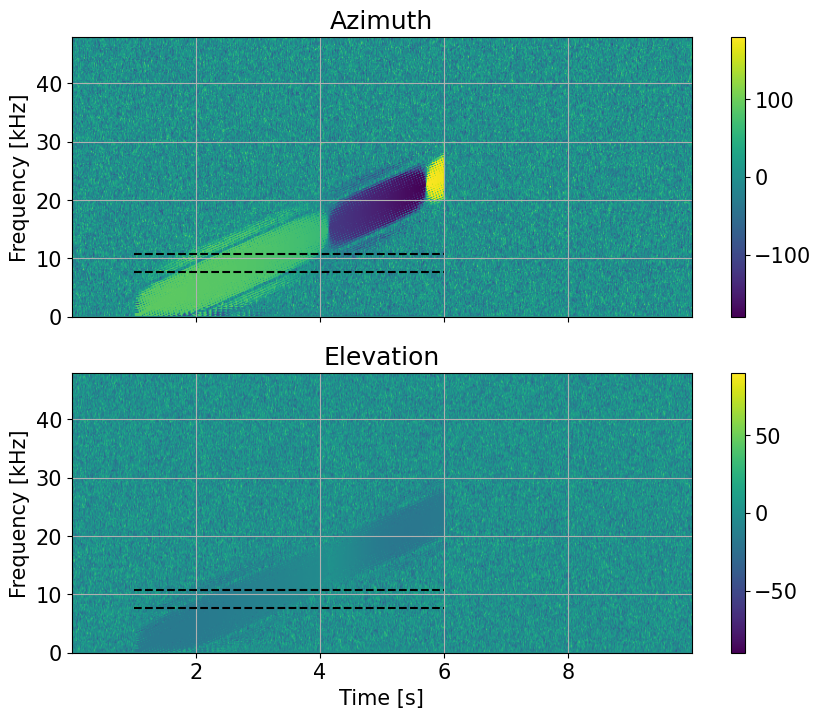

In [5]:
# intensity vector
#
def intens_dir(ss,fs,nw,nover,nfft,DI,isel):
    # use spectrogram
    f,t,Q= sig.spectrogram(ss,axis=0,fs=fs,nperseg=nw,noverlap=nover,nfft=nfft,
                           scaling='spectrum',mode='complex') #format: (nft,nisel,nsamp)
    #
    C = Q[:,isel[:,0],:]*np.conjugate(Q[:,isel[:,1],:]) 
    #
    # spectral intensity estimate
    C = -np.imag(C).swapaxes(1,2) # swap from (nfr,nisel,nsamp) to (nfr,nsamp,nisel)
    I = C @ DI.T
    
    Azx=180/np.pi*np.arctan2(I[:,:,1],I[:,:,0])
    Elx=180/np.pi*np.arctan2(I[:,:,2],np.sqrt(I[:,:,0]**2+I[:,:,1]**2))

    return Azx,Elx,I,t,f
##---------------------------------------------------------------
nw=256
nover=3*nw/4
nfft=2*nw
a,b,I,t,f = intens_dir(ss,fs,nw,nover,nfft,DI,isel)
#
ext=(t[0],t[-1],f[0]/1000,f[-1]/1000)

fig = plt.figure("figsize",[10,8])
plt.subplot(211)
plt.imshow(a,origin='lower', aspect='auto',extent=ext)
plt.gca().set_xticklabels([])
#plt.xlim(xl)
plt.hlines(np.min(0.75/L),to,to+t2,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),to,to+t2,colors='k',linestyles='--')
plt.colorbar()
plt.grid(True)
plt.ylabel('Frequency [kHz]')
plt.title('Azimuth')

plt.subplot(212)
plt.imshow(b,origin='lower', aspect='auto',extent=ext)
#plt.xlim(xl)
plt.hlines(np.min(0.75/L),to,to+t2,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),to,to+t2,colors='k',linestyles='--')
plt.colorbar()

plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title('Elevation')

plt.show()


The figure shows the estimated azimuth and elevation angles as function of frequency versus time. The two horizontal dashed lines indicate the two spectral limits where unique phase-based operations are unique. The lower line considers all hydrophone pairs (including the 3 longer cross-diagonal ones) and the upper line corresonds to the 12 'normal' hydrophone pairs.

### Direction finding using phase differences

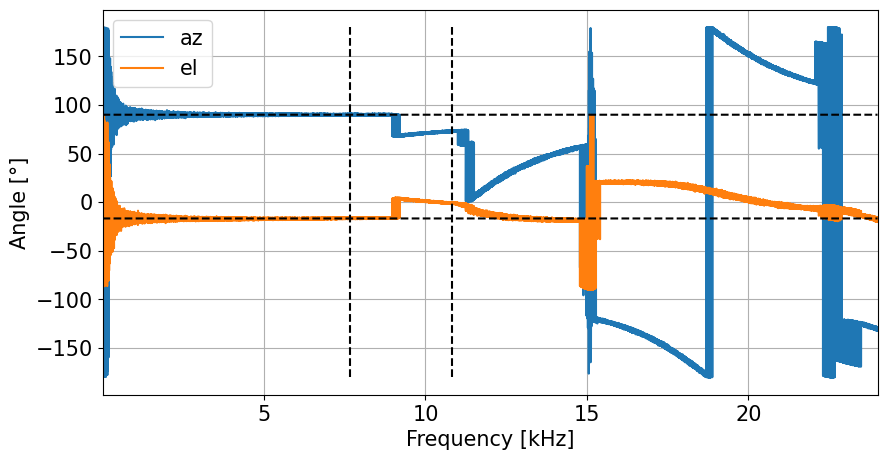

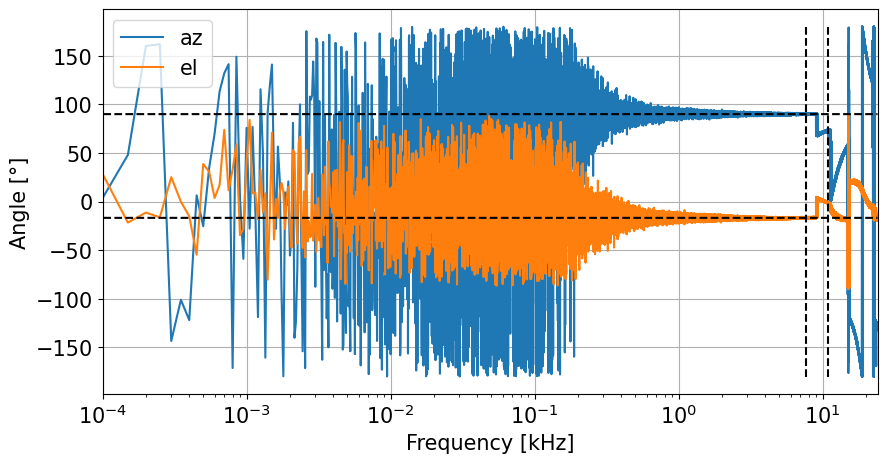

In [6]:
# phase differences
#
def phase_dir(ss,isel,DI):
    # use phase shifts
    zz=hilbert_filt(ss,50)
    
    uu = -np.log(zz[:,isel[:,0]]*np.conjugate(zz[:,isel[:,1]])).imag  
    vv=uu @ DI.T

    azx=180/np.pi*np.arctan2(vv[:,1],vv[:,0])
    elx=180/np.pi*np.arctan2(vv[:,2],np.sqrt(vv[:,0]**2+vv[:,1]**2))
    return azx,elx
#--------------------------------------------------------------------------
azx,elx=phase_dir(ss,isel,DI)

frx=fr/1000
ifr=int(to*fs)+np.arange(len(frx),dtype='int')

def phase_plot(scale):
    fig = plt.figure("figsize",[10,5])
    plt.plot(frx,azx[ifr], label='az')
    plt.plot(frx,elx[ifr], label='el')
    plt.plot(frx,180/np.pi*az+0*frx,'k--')
    plt.plot(frx,180/np.pi*el[0]+0*frx,'k--')
    plt.vlines(np.min(0.75/L),-180,180,colors='k',linestyles='--')
    plt.vlines(np.max(0.75/L),-180,180,colors='k',linestyles='--')
    plt.xlim(1e-4,24)
    plt.gca().set_xscale(scale)
    plt.grid(True)
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('Angle [°]')
    plt.legend()
    plt.show()

phase_plot('linear')
phase_plot('log')

### Direction finding using time-delay-of-arrival (tdoa) 
As the signal is simulated as a linear frequency modulated time series, it is appropriate to pre-process the data using a matched filter to compress the signal into sharp transients. Using these shortened signals, standard time-delay-of arrival (tdoa) methods can be applied to obtain the direction of the sound source.

89.9329274409379 -16.618101253704705
[ 90.         -16.69924423]


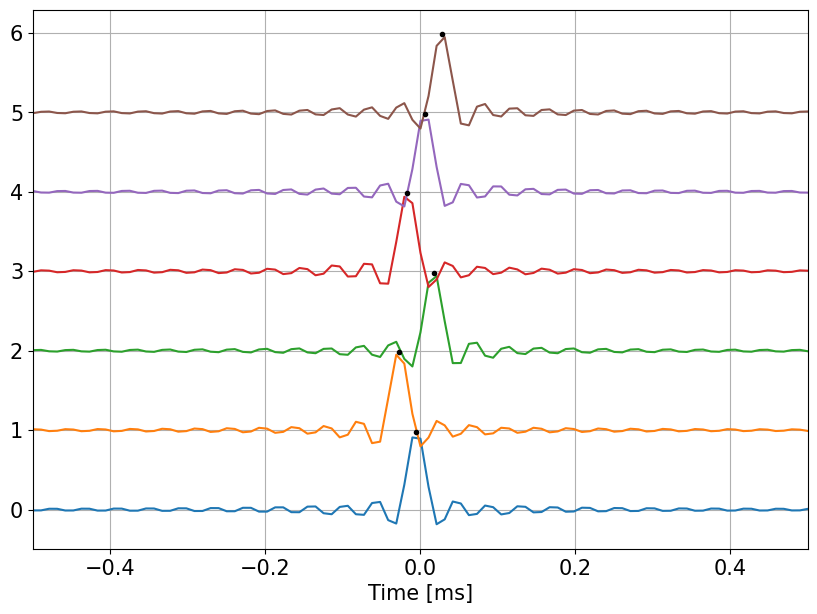

In [7]:
#
def tdoa_dir(zz,DI,isel):
    # use time differences of temporal maxima
    imx=np.argmax(zz,axis=0)
    ux=quadInt(zz,imx,0)
    #
    uu=ux[isel[:,0],0]-ux[isel[:,1],0]
    #
    vv=uu @ DI.T

    azx=180/np.pi*np.arctan2(vv[1],vv[0])
    elx=180/np.pi*np.arctan2(vv[2],np.sqrt(vv[0]**2+vv[1]**2))
    return azx,elx,ux

# matched filter 
zz=matched_filt(xx,ss)
# tdoa
azx,elx,ux = tdoa_dir(zz,DI,isel)

print(azx,elx)
print(np.array([az,el[0]])*180/np.pi)

tux=ux[:,0]/fs

n1,n2=zz.shape
n3=ux.shape[0]

plt.figure(figsize=(10,7))
plt.plot((ty-np.mean(tux))*1000,zz+np.ones((n1,1))*range(n2))
plt.plot((tux-np.mean(tux))*1000,ux[:,1]+np.arange(n3),'k.')
plt.xlim(-0.5,0.5)
plt.grid(True)
plt.xlabel('Time [ms]')
plt.show()



The figure shows the output of the matched filter for all hydrophones and the time delays are clearly visible. For each of the transient the time of the maximum was obtained by quadratic interpolation of 3 relevant samples. The estimated sound direction (azimuth and elevation)  are very close to the simulated one.

### Direction finding using hydrophone cross correlation

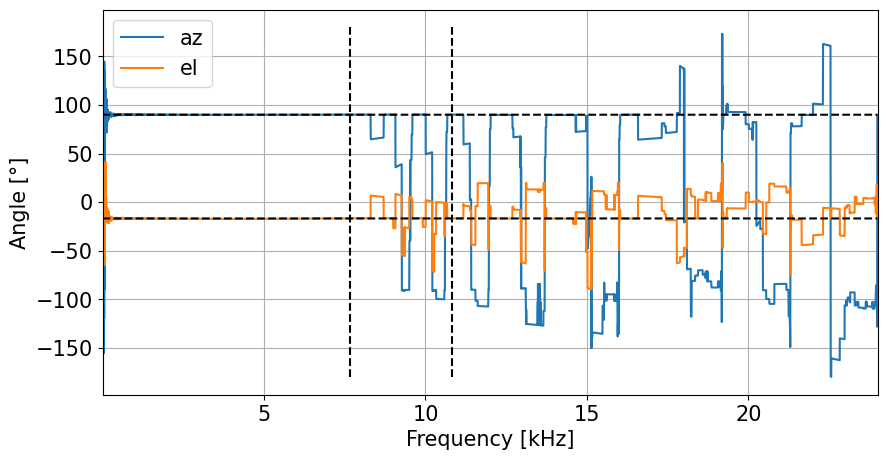

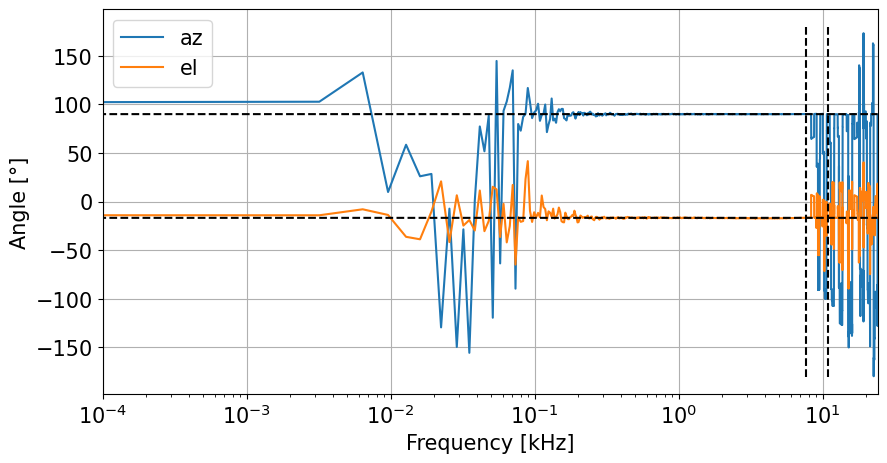

In [8]:
# use xcorr
def quadInt1(C,infft,dn):
    # simple quadratic estimate interpolated maxima
    # limit location of maxima to infft +- (dn-1)
    uu=C[infft//2-dn:infft//2+dn,:,:]
    imx=np.argmax(uu[1:-1],axis=0)+1
    vv=np.zeros((uu.shape[1],uu.shape[2]))
    for ii in range(uu.shape[1]):
        dd=uu[:,ii,:]
        ux=quadInt(dd,imx[ii,:],dn)
        vv[ii,:]=ux[:,0]
    return vv
#
def xcorr_dir(ss,fs,nw,nover,nfft,DI,isel):
    # use spectrogram
    f,t,Q= sig.spectrogram(ss,axis=0,fs=fs,nperseg=nw,noverlap=nover,nfft=nfft,
                           scaling='spectrum',mode='complex') #format: (nft,nisel,nsamp)
    #
    C = Q[:,isel[:,0],:]*np.conjugate(Q[:,isel[:,1],:])
    #
    # cross-correlation estimate
    infft=nfft
    C = np.fft.irfft(C,axis=0,n=infft).swapaxes(1,2)
    C = np.fft.fftshift(C,axes=0)

    #find cross-correlation peak
    dn=1+int(np.ceil(np.max(L/1500*fs)))
    uu=quadInt1(C,infft,dn)
    vv=uu @ DI.T

    azx=180/np.pi*np.arctan2(vv[:,1],vv[:,0])
    elx=180/np.pi*np.arctan2(vv[:,2],np.sqrt(vv[:,0]**2+vv[:,1]**2))

    return azx,elx,t,f

nw=256
nover=3*nw/4
nfft=2*nw
azx,elx,t,f=xcorr_dir(ss,fs,nw,nover,nfft,DI,isel)

nstep=int(nw-nover)
frx=fr[::nstep]/1000
ifr=int(to*fs/nstep)+np.arange(len(frx),dtype='int')

def xcorr_plot(scale):
    fig = plt.figure("figsize",[10,5])
    plt.plot(frx,azx[ifr],label='az')
    plt.plot(frx,elx[ifr],label='el')
    plt.plot(frx,180/np.pi*az+0*frx,'k--')
    plt.plot(frx,180/np.pi*el[0]+0*frx,'k--')
    plt.vlines(np.min(0.75/L),-180,180,colors='k',linestyles='--')
    plt.vlines(np.max(0.75/L),-180,180,colors='k',linestyles='--')
    plt.xlim(1e-4,24)
    plt.gca().set_xscale(scale)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('Angle [°]')
    plt.show()

xcorr_plot('linear')
xcorr_plot('log')

### Simulate direction finding of noise source 

Angles:  [ 90.          26.33541     26.79377563 -52.3246524 ]
Time delays:  2.981400118798774 346.9031892640637
[-0.00836508  0.01233206 -0.02906222  0.02906222  0.00836508 -0.01233206] ms
[-0.0085      0.01211452 -0.02911452  0.02911452  0.0085     -0.01211452] ms
[ 0.01492441  0.02903916  0.00080967 -0.00080967 -0.01492441 -0.02903916] ms


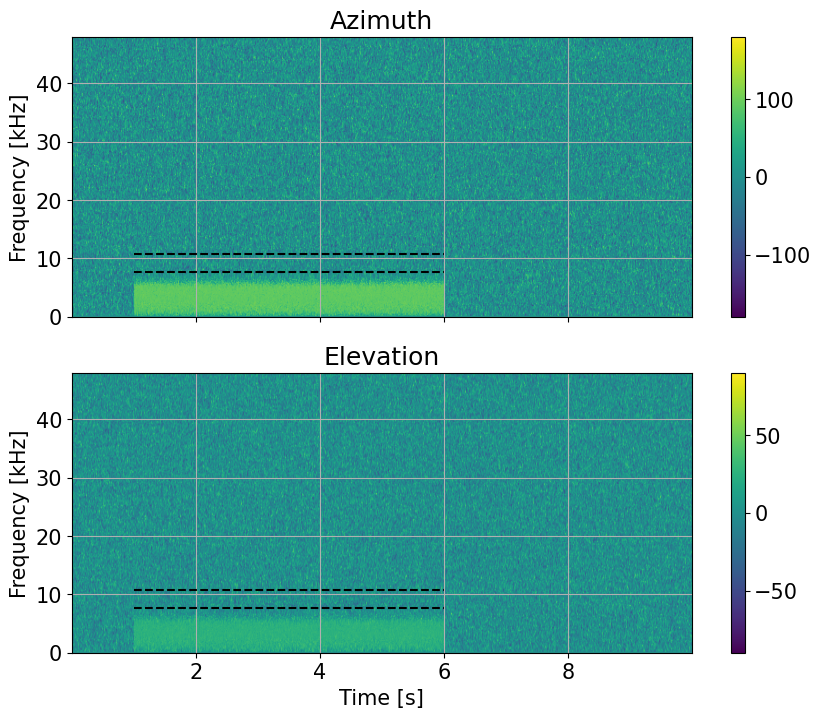

In [9]:
def ship_simulate(fs,t2,to,te,noise):
    # generate time vector
    tt=np.arange(0,t2,1/fs)
    xx=np.random.normal(scale=noise,size=tt.shape)
    #
    nw=128
    ww=sig.firwin(nw,0.1)
    ss=fft_filt(ww,xx,nh=nw//2)
    #
    iyo=int(to*fs)
    iye=int(te*fs)
    yy=np.zeros((iye,1))
    #
    yy[iyo:iyo+len(ss)]+=ss
    ty=np.arange(len(yy))/fs

    return yy,ty

#simulate ship noise
az=90*np.pi/180
bd=900 # bottom depth m
hd=500 # hydrophone depth m
sd=5 # source depth m
dx=1000 # source distance m

t2=5        # LFM duration (s)

to=1        # signal start time (to>=0)
te=10       # data end time (te >=to+t2)

ship_noise=0.1 # coherent noise
syst_noise=0.01 # incoherent noise

DT,el,rx=geometry(hd,sd,dx,bd,az,ho)
yy,ty=ship_simulate(fs,t2,to,te,ship_noise)
ss=map_array(yy,fs,DT[0],syst_noise)

#
#----------------------------------------------------------------------
nw=256
nover=3*nw/4
nfft=2*nw
a,b,I,t,f = intens_dir(ss,fs,nw,nover,nfft,DI,isel)
#
ext=(t[0],t[-1],f[0]/1000,f[-1]/1000)

fig = plt.figure("figsize",[10,8])
plt.subplot(211)
plt.imshow(a,origin='lower', aspect='auto',extent=ext)
plt.gca().set_xticklabels([])
#plt.xlim(xl)
plt.hlines(np.min(0.75/L),to,to+t2,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),to,to+t2,colors='k',linestyles='--')
plt.colorbar()
plt.grid(True)
plt.ylabel('Frequency [kHz]')
plt.title('Azimuth')

plt.subplot(212)
plt.imshow(b,origin='lower', aspect='auto',extent=ext)
#plt.xlim(xl)
plt.hlines(np.min(0.75/L),to,to+t2,colors='k',linestyles='--')
plt.hlines(np.max(0.75/L),to,to+t2,colors='k',linestyles='--')
plt.colorbar()

plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title('Elevation')

plt.show()


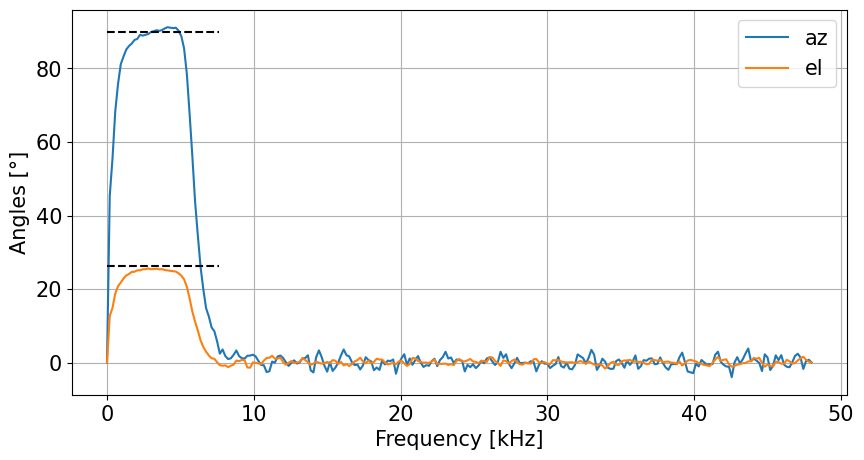

In [10]:
ix=((t>to)&(t<(to+t2)))
#
plt.figure(figsize=(10,5))
plt.plot(f/1000,np.mean(a[:,ix],axis=1),label='az')
plt.plot(f/1000,np.mean(b[:,ix],axis=1),label='el')
plt.hlines(az*180/np.pi,0,np.min(0.75/L),colors='k',linestyles='--')
plt.hlines(el[0]*180/np.pi,0,np.min(0.75/L),colors='k',linestyles='--')
plt.grid(True)
plt.xlabel('Frequency [kHz]')
plt.ylabel('Angles [°]')
plt.legend()
plt.show()

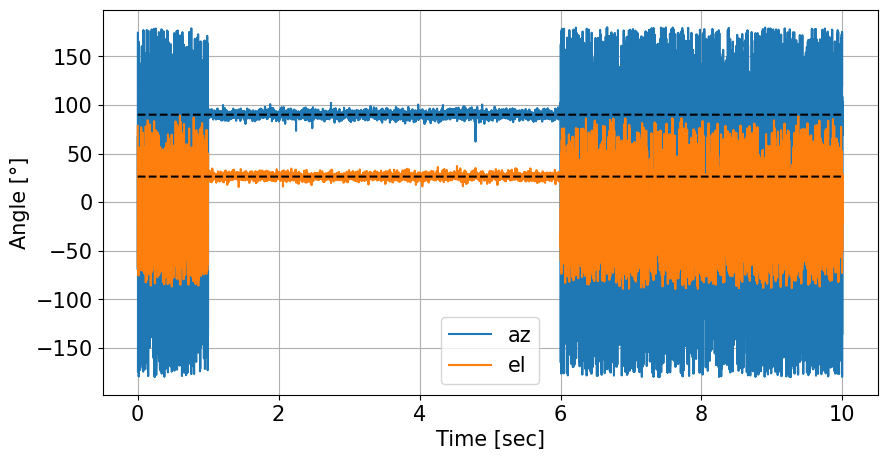

In [11]:

nw=256
nover=3*nw/4
nfft=2*nw
azx,elx,t,f=xcorr_dir(ss,fs,nw,nover,nfft,DI,isel)

def xcorr1_plot(scale):
    fig = plt.figure("figsize",[10,5])
    plt.plot(t,azx,label='az')
    plt.plot(t,elx,label='el')
    plt.plot(t,180/np.pi*az+0*t,'k--')
    plt.plot(t,180/np.pi*el[0]+0*t,'k--')
    plt.gca().set_xscale(scale)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time [sec]')
    plt.ylabel('Angle [°]')
    plt.show()

xcorr1_plot('linear')


In [12]:
ro=0.040 # m
dz=np.sqrt(2)
ang=np.array([0,120,240,60,180,300])*np.pi/180
#
ho=np.empty((len(ang),3))
ho[:,:]=np.transpose([np.cos(ang[:]),np.sin(ang[:]),-dz/2+0*ang[:]])
ho[3:,2] += dz
ho *= ro
isel=np.array([[0,1],[0,2],[0,3],[0,4],[0,5],
                [1,2],[1,3],[1,4],[1,5],
                [2,3],[2,4],[2,5],
                [3,4],[3,5],
                [4,5]])

nc=np.shape(isel)[0]


#simulate signal arrival direct, surface and bottom reflected
az=150*np.pi/180
bd=900 # bottom depth m
hd=500 # hydrophone depth m
sd=800 # source depth m
dx=5000 # source distance m
#

D=ho[isel[:,1],]-ho[isel[:,0],]
L=np.sqrt(np.sum(D**2,1))
DI=np.linalg.pinv(D)
print(D)

dy=hd-sd
r1=np.sqrt(dx**2 + dy**2)
print(r1)
el1=np.arctan2(dy,dx)
#
S1=np.array([np.cos(az)*np.cos(el1),np.sin(az)*np.cos(el1), np.sin(el1)])
print(S1)

[[-6.00000000e-02  3.46410162e-02  0.00000000e+00]
 [-6.00000000e-02 -3.46410162e-02  0.00000000e+00]
 [-2.00000000e-02  3.46410162e-02  5.65685425e-02]
 [-8.00000000e-02  4.89858720e-18  5.65685425e-02]
 [-2.00000000e-02 -3.46410162e-02  5.65685425e-02]
 [-2.77555756e-17 -6.92820323e-02  0.00000000e+00]
 [ 4.00000000e-02  0.00000000e+00  5.65685425e-02]
 [-2.00000000e-02 -3.46410162e-02  5.65685425e-02]
 [ 4.00000000e-02 -6.92820323e-02  5.65685425e-02]
 [ 4.00000000e-02  6.92820323e-02  5.65685425e-02]
 [-2.00000000e-02  3.46410162e-02  5.65685425e-02]
 [ 4.00000000e-02 -6.93889390e-18  5.65685425e-02]
 [-6.00000000e-02 -3.46410162e-02  0.00000000e+00]
 [ 0.00000000e+00 -6.92820323e-02  0.00000000e+00]
 [ 6.00000000e-02 -3.46410162e-02  0.00000000e+00]]
5008.991914547278
[-0.86447075  0.49910242 -0.05989229]
